# 1. Imports

In [55]:
import json
import random
import pickle
import requests
import inflection
import pandas     as pd
import numpy      as np
import seaborn    as sns
import sweetviz   as sv
import scikitplot as skplt

from flask        import Flask, request, Response
from tabulate     import tabulate
from sklearn      import ensemble        as en
from sklearn      import neighbors       as nh
from sklearn      import preprocessing   as pp
from sklearn      import model_selection as ms
from sklearn      import linear_model    as lm
from matplotlib   import pyplot          as plt

import warnings
warnings.filterwarnings( 'ignore' )

# 2. Helper functions

In [56]:
def description_cols():
    description = [
    ['Variable', 'Definition'],
    ['id', 'Customer Iedntifier'],
    ['Gender', 'Customer Gender'],
    ['Age', 'Customer Age'],
    ['Driving_License', '0 : Customer does not have DL, 1 : Customer already has DL'],
    ['Region_Code', 'Customer Region Code'],
    ['Previously_Insured', '1 : Customer already has Vehicle Insurance, 0 : Customer doesn\'t have Vehicle Insurance'],
    ['Vehicle_Age', 'Vehicle Age'],
    ['Vehicle_Damage', '1 : Customer has already had damage to their car. 0 : Customer has never had damaged to their car'],
    ['Annual_Premium', 'Amount paid to the company for health insurance, annualy'],
    ['Policy_Sales_Channel', 'Anonymous code for customer contact'],
    ['Vintage', 'Number of days the customer purchased health insurance'],
    ['Response', '1 : Interested Customer, 0 : Not interested customer']
    ]

    print(tabulate(description, headers='firstrow', tablefmt='fancy_grid', showindex=True))

def rename_columns(data):
    new_columns = {col: inflection.underscore(col) for col in data.columns}
    return data.rename(columns=new_columns)

def feature_engineering(data):
        # vehicle age
    data['vehicle_age'] = data['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' 
                                                else 'between_1_2_year' if x == '1-2 Year' 
                                                else 'below_1_year' ) 

    # vehicle damage
    data['vehicle_damage'] = data['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

    return data

def standardization_data( data ):
    # annual_premium
    ss = pp.StandardScaler()
    data['annual_premium'] = ss.fit_transform(data[['annual_premium']].values)
    pickle.dump(ss, open('../src/features/annual_premium_scaler.pkl', 'wb'))

    return data

def rescaling_data( data ):
    # age (por causa do gráfico)
    mms_age = pp.MinMaxScaler()
    data['age'] = mms_age.fit_transform(data[['age']].values)
    pickle.dump(mms_age, open('../src/features/age_scaler.pkl', 'wb'))

    # vintage (por causa do gráfico)
    mms_vintage = pp.MinMaxScaler()
    data['vintage'] = mms_vintage.fit_transform(data[['vintage']].values)
    pickle.dump(mms_vintage, open('../src/features/vintage_scaler.pkl', 'wb'))

    return data

def encoding_data( data ):
    # gender - Target Encoding** / One Hot Encoding 
    target_encode_gender = data.groupby('gender')['response'].mean()
    data.loc[:,'gender'] = data['gender'].map(target_encode_gender)
    pickle.dump(target_encode_gender, open('../src/features/target_encode_gender_scaler.pkl', 'wb'))

    # region_code -  One Hot Encoding (until 6 different types) / Frequency Encoding / Target Encoding** / Weighted Encoding
    target_encode_region_code = data.groupby('region_code')['response'].mean()
    data.loc[:,'region_code'] = data['region_code'].map(target_encode_region_code)
    pickle.dump(target_encode_region_code, open('../src/features/target_encode_region_code_scaler.pkl', 'wb'))

    # vehicle_age (categorical variable)  One Hot Encoding** / Order Encoding / Frequency Encoding
    data = pd.get_dummies(data, prefix='vehicle_age', columns=['vehicle_age'])

    # policy_sales_channel - Target Encoding / Frequency Encoding**
    fe_policy_sales_channel = data.groupby('policy_sales_channel').size() / len(data)
    data.loc[:,'policy_sales_channel'] = data['policy_sales_channel'].map(fe_policy_sales_channel)
    pickle.dump(fe_policy_sales_channel, open('../src/features/fe_policy_sales_channel_scaler.pkl', 'wb'))
    
    return data

def precision_at_k(data, k=2000):
    # reset index
    data = data.reset_index(drop=True)
    # create ranking order
    data['ranking'] = data.index + 1
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']

def recall_at_k(data, k=2000):
    # reset index
    data = data.reset_index(drop=True)
    # create ranking order
    data['ranking'] = data.index + 1
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']

def metrics_models(data, model_name, y_val, yhat, x_val):
    data = x_val.copy()
    data['response'] = y_val.copy()
    # Score
    data['score'] = yhat[:,1].tolist()
    # Sorting customers by propensity score
    data = data.sort_values('score', ascending=False)

    # Calculate Precision at K
    precision = precision_at_k(data, k=2000)
    # Calculate Recall at k
    recall =  recall_at_k(data, k=2000)

    return pd.DataFrame({'Model Name': model_name,
                         'Precision at K': precision,
                         'Recall at K': recall}, index=[0])

# 3. Loading Data

In [57]:
df_raw = pd.read_csv('../data/train.csv', low_memory=False)
df_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# 4. Data Description

## 4.0 Description

In [58]:
description_cols()

╒════╤══════════════════════╤═══════════════════════════════════════════════════════════════════════════════════════════════════╕
│    │ Variable             │ Definition                                                                                        │
╞════╪══════════════════════╪═══════════════════════════════════════════════════════════════════════════════════════════════════╡
│  0 │ id                   │ Customer Iedntifier                                                                               │
├────┼──────────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────┤
│  1 │ Gender               │ Customer Gender                                                                                   │
├────┼──────────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────┤
│  2 │ Age                  │ Customer Age                                                

In [59]:
df1 = df_raw.copy()
df1 = rename_columns(df1)
df1.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 4.1 Data Dimension

In [60]:
df1.shape

(381109, 12)

## 4.2 Data Types

In [61]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 4.3 Check NA

In [62]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 4.4 Data Descriptive

In [63]:
num_attributes = df1.select_dtypes(include=(['int64', 'float64']))
cat_attributes = df1.select_dtypes(exclude=(['int64', 'float64', 'datetime64[ns]']))

In [64]:
# Central Tendency - Mean, Median
mean_ = pd.DataFrame(num_attributes.apply(np.mean)).T
median_ = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
std_ = pd.DataFrame(num_attributes.apply(np.std)).T
min_ = pd.DataFrame(num_attributes.apply(min)).T
max_ = pd.DataFrame(num_attributes.apply(max)).T
range_ = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
skew_ = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
kurtosis_ = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat( [min_, max_, range_, mean_, median_, std_, skew_, kurtosis_] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std',
             'skew', 'kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


## 4.5 Categorical Variables

In [65]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

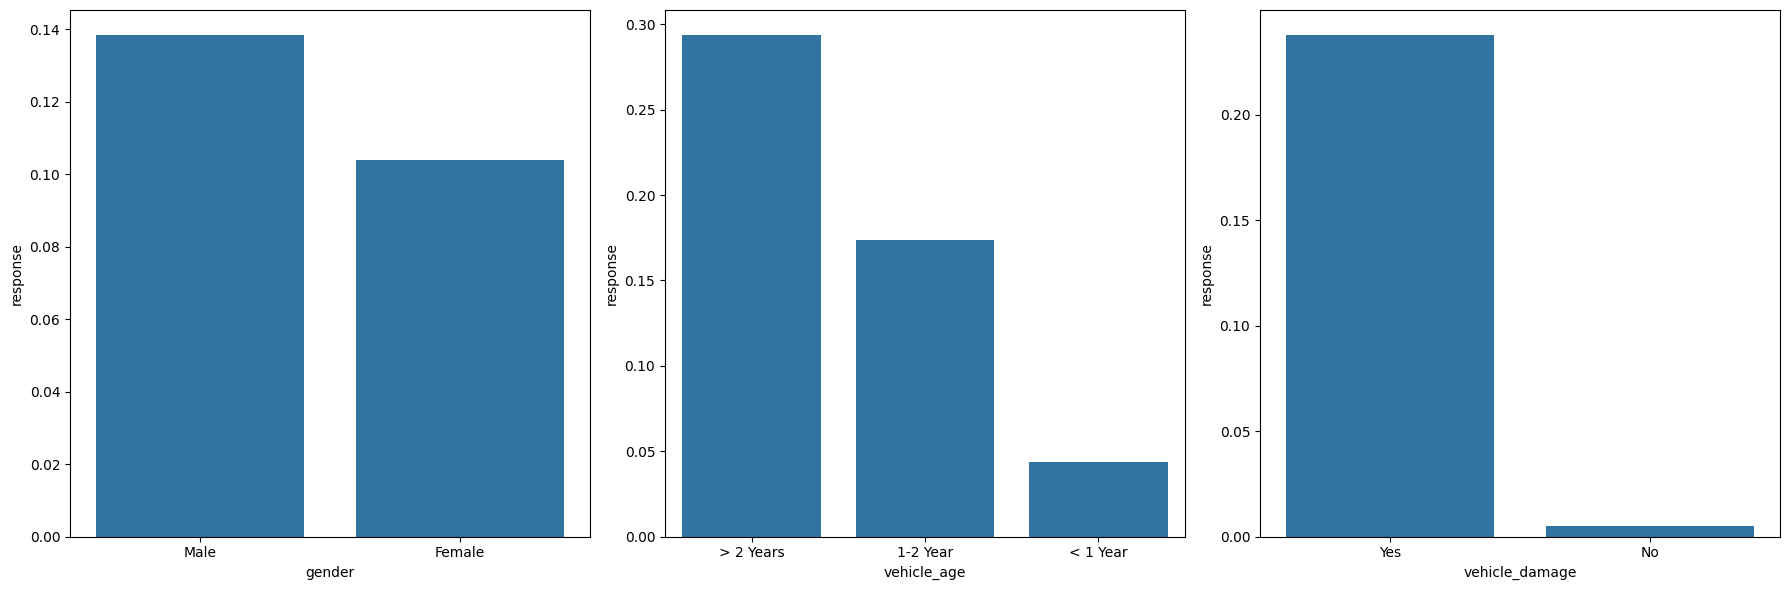

In [66]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
sns.barplot(x='gender', y='response', data=df1, errorbar=None)

plt.subplot(1,3,2)
sns.barplot(x='vehicle_age', y='response', data=df1, errorbar=None)

plt.subplot(1,3,3)
sns.barplot(x='vehicle_damage', y='response', data=df1, errorbar=None)

plt.tight_layout()
plt.show()

# 5. Feature Engineering

In [67]:
df2 = df1.copy()

In [68]:
df2 = feature_engineering(df2)

# 6. Data Filtering

In [69]:
df3 = df2.copy()

# 7. EDA

In [70]:
df4 = df3.copy()

# For classification projects, we need to clustering two classes or two groups.
# In this case, one group interested in vehicle insurance and another not.

## 7.1 Univariate Analysis

### 7.1.1 Age

- There is a lot of data (25,000) on 'not interested' concentrated on age 20-25.
- There is little data (1,750) in 'interested'. The highest concentration is in people aged 40-50.
- This variable is promising for separating the set into two classes, but it is unbalanced.

<Axes: xlabel='response', ylabel='age'>

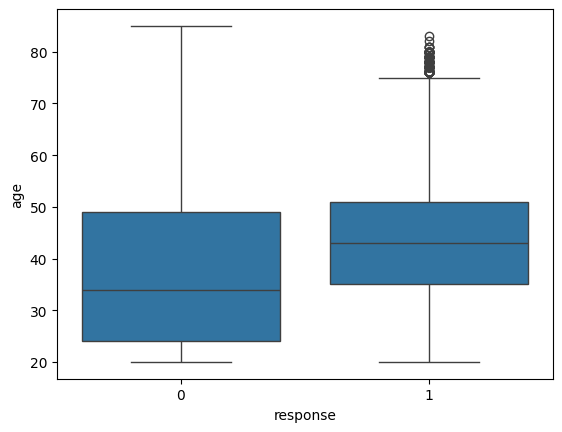

In [71]:
sns.boxplot(x='response', y='age', data=df4)

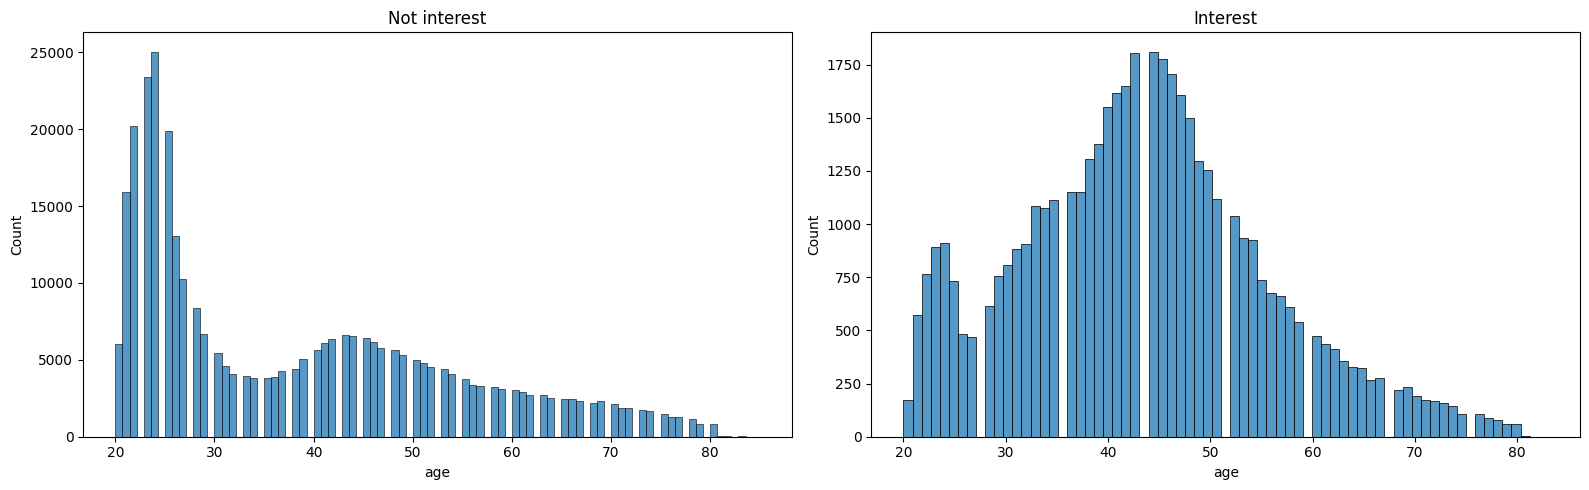

In [72]:
plt.figure(figsize=(16,5))

plt.subplot(1, 2, 1)
plt.title('Not interest')
aux0 = df4.loc[df4['response'] == 0, 'age']
sns.histplot(aux0)

plt.subplot(1, 2, 2)
plt.title('Interest')
aux1 = df4.loc[df4['response'] == 1, 'age']
sns.histplot(aux1)

plt.tight_layout()
plt.show()

### 7.1.2 Annual Premium

- This variable alone is not relevant. Maybe combined with another.
- Similar shapes and medians. Cannot target groups.

<Axes: xlabel='response', ylabel='annual_premium'>

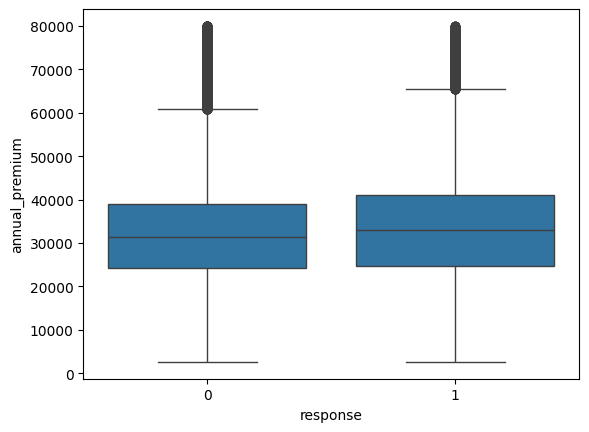

In [73]:
aux = df4[df4['annual_premium'] < 80000]
sns.boxplot(x='response', y='annual_premium', data=aux)

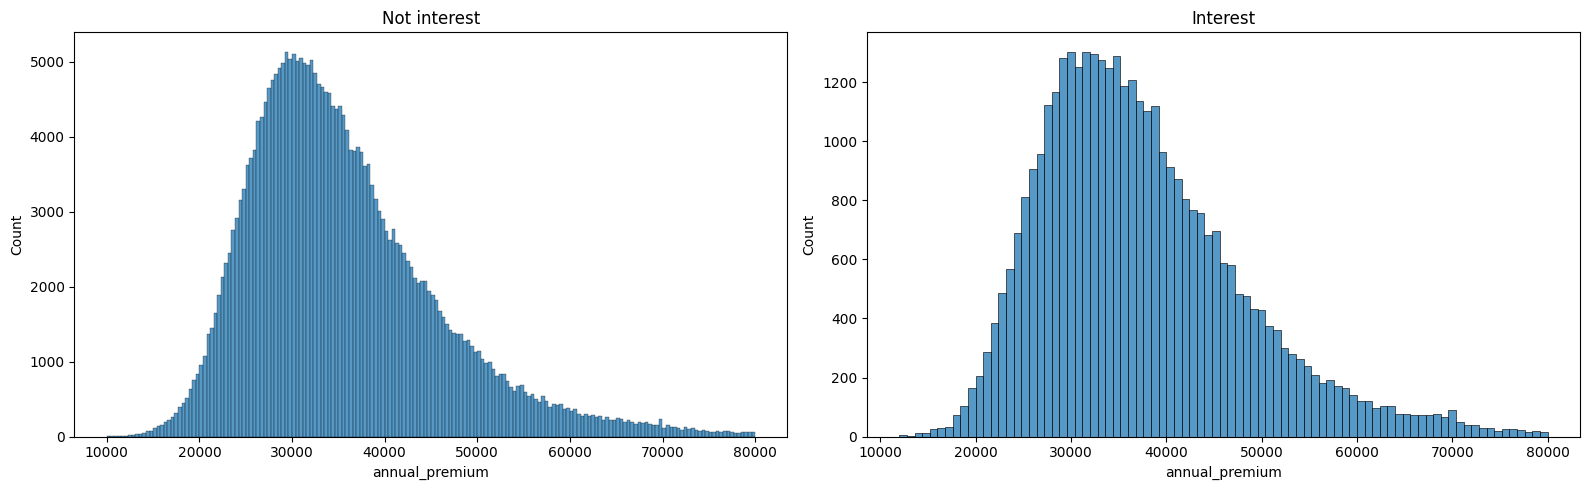

In [74]:
plt.figure(figsize=(16,5))
aux = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]

plt.subplot(1, 2, 1)
plt.title('Not interest')
aux0 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot(aux0)

plt.subplot(1, 2, 2)
plt.title('Interest')
aux1 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot(aux1)

plt.tight_layout()
plt.show()

### 7.1.3 Driving License

- There is group segmentation. Important variable, but must be combined with age.
- There are many people with a driving license who do not want car insurance. Investigate the reason.

In [75]:
aux = df4[['driving_license', 'response']].groupby('response').sum().reset_index()
aux['driving_license_perc'] = aux['driving_license'] / aux['driving_license'].sum()
aux.head()

,response,driving_license,driving_license_perc
0,0,333628,0.877283
1,1,46669,0.122717


<Axes: xlabel='response', ylabel='driving_license'>

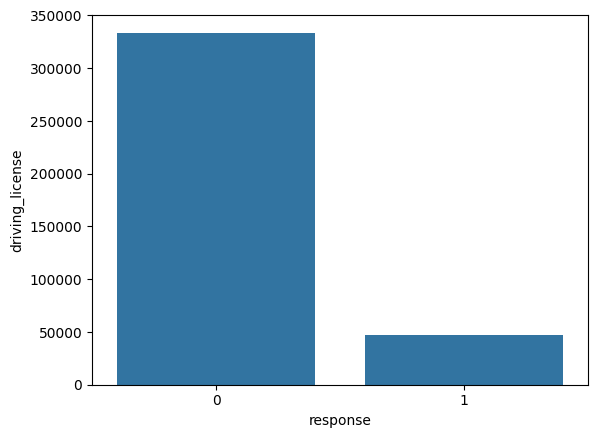

In [76]:
sns.barplot(x='response', y='driving_license', data=aux)

### 7.1.4 Region Code

- Did not create cluster groups.
- Alone, this variable is not interesting. Perhaps combined with another variable it would be useful.

<Axes: xlabel='region_code', ylabel='id'>

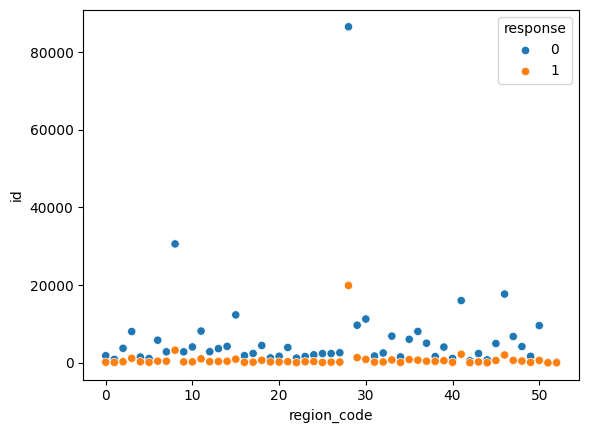

In [77]:
aux0 = df4[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()
sns.scatterplot(data=aux0, x='region_code', y='id', hue='response')

### 7.1.5 Previously Insured

- People who already have vehicle insurance do not want to exchange their insurance for the company's.
- There is a data leak: the previously_insurance variable is almost telling the model the answer.
- The correlation with the response variable is very high, as if those who already have vehicle insurance would not buy the company's insurance.
- Almost an if/else (if you have insurance -> don't buy it)

In [78]:
pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: x/x.sum(), axis=1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


- 0 0 = People who DO NOT have health insurance and DO NOT want car insurance
- 0 1 = People who DO NOT have health insurance and want car insurance
- 1 0 = People who have health insurance and do NOT want car insurance
- 1 1 = People who have health insurance and want car insurance

### 7.1.6 Vehicle Age

- For new cars up to 1 year old and those 1-2 years old, there is group discrimination.
- For older cars, the groups are similar.

In [79]:
df4[['vehicle_age', 'response']].value_counts(normalize=True).reset_index().sort_values('vehicle_age')
# sns.scatterplot(data=aux0, x='vehicle_age', y='id', hue='response')

,vehicle_age,response,proportion
1,below_1_year,0,0.413488
4,below_1_year,1,0.018897
0,between_1_2_year,0,0.434285
2,between_1_2_year,1,0.091328
3,over_2_years,0,0.029663
5,over_2_years,1,0.012338


### 7.1.7 Vehicle Damage

- People with a damaged vehicle are more likely to buy than those without damage.

In [80]:
df4[['vehicle_damage', 'response']].value_counts(normalize=True).reset_index().sort_values('vehicle_damage')

,vehicle_damage,response,proportion
0,0,0,0.492547
3,0,1,0.002577
1,1,0,0.384890
2,1,1,0.119987


### 7.1.8 Gender

- There is clustering of groups.

In [81]:
df4[['gender', 'response']].value_counts(normalize=True).reset_index().sort_values('gender')

,gender,response,proportion
1,Female,0,0.411523
3,Female,1,0.047716
0,Male,0,0.465914
2,Male,1,0.074847


### 7.1.9 Policy Sales Channel

- Channels 43 and 123 are the best for those who want insurance.

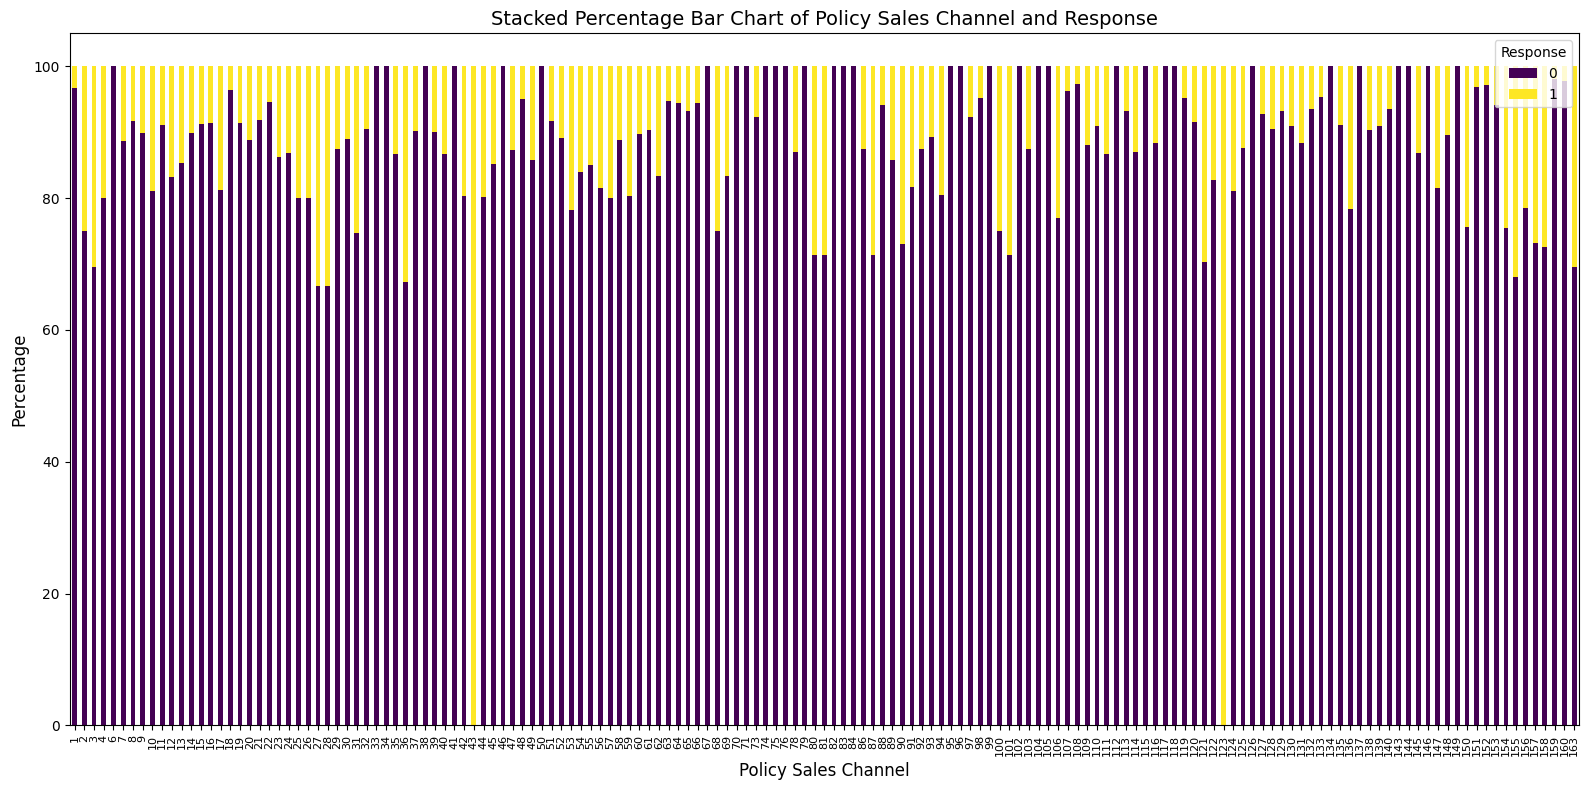

In [82]:
# Prepare the data for the stacked bar chart
stacked_data = (df4.groupby(['policy_sales_channel', 'response']).size()
                .unstack(fill_value=0))

# Convert counts to percentages
stacked_data_percentage = stacked_data.div(stacked_data.sum(axis=1),
                                           axis=0) * 100

# Plot
stacked_data_percentage.plot(kind='bar', stacked=True, figsize=(16, 8),
                             colormap='viridis')

# Add labels and title
plt.title('Stacked Percentage Bar Chart of Policy Sales Channel and Response',
          fontsize=14)
plt.xlabel('Policy Sales Channel', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.legend(title='Response', loc='upper right', fontsize=10)
plt.xticks(range(len(stacked_data_percentage.index)), 
           labels=stacked_data_percentage.index.astype(int), 
           rotation=90, fontsize=8)
plt.tight_layout()

# Show the plot
plt.show()


### 7.1.10 Vintage

- There is no group segmentation. The data is homogeneous. 
- The distribution is uniform.
- Irrelevant variable.

<Axes: xlabel='response', ylabel='vintage'>

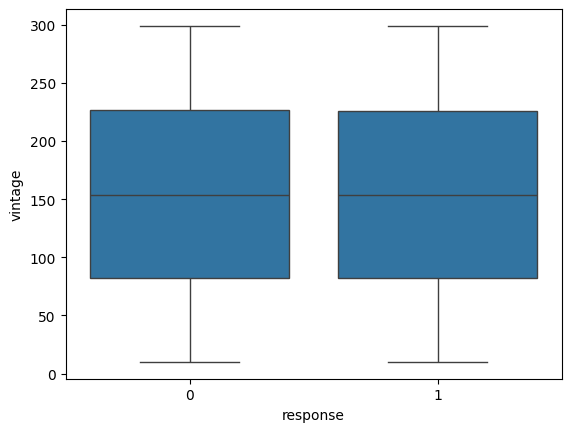

In [83]:
sns.boxplot(x='response', y='vintage', data=df4)

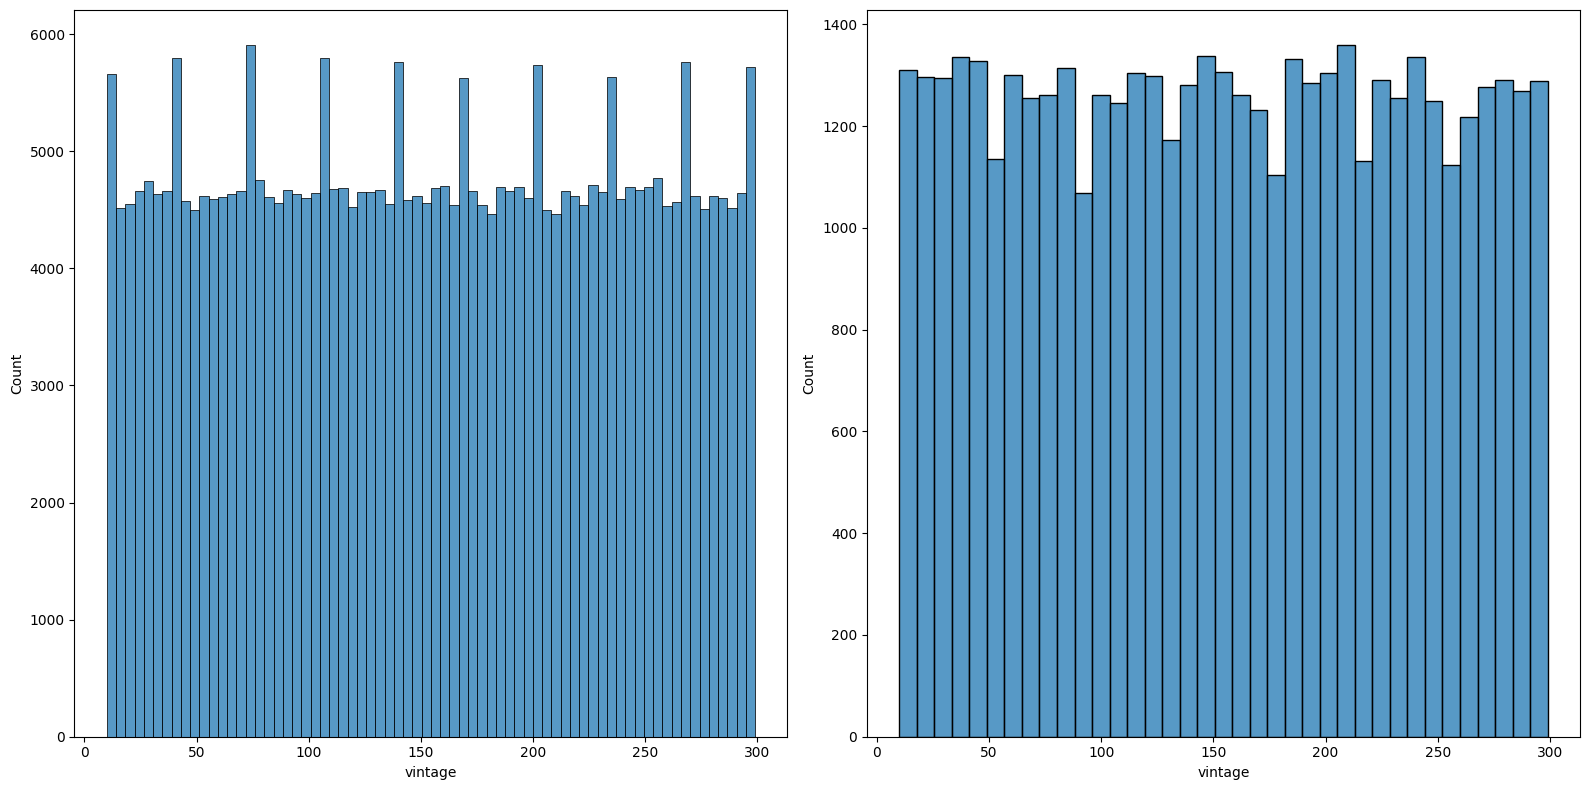

In [84]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
aux = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot(aux) 

plt.subplot(1, 2, 2)
aux1 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot(aux1)

plt.tight_layout()
plt.show()

# 8. Data Preparation

In [85]:
df5 = df4.copy()

In [86]:
X = df4.drop('response', axis=1)
y = df4['response'].copy()

x_train, x_val, y_train, y_val = ms.train_test_split(X, y, test_size=0.20)
df5 = pd.concat([x_train, y_train], axis=1)

In [87]:
# Standarization
df5 = standardization_data(df5)

# Rescaling
df5 = rescaling_data(df5)

# Encoder
df5 = encoding_data(df5)

## 8.1 Validation Data Preparation

In [88]:
# df5_val = pd.concat( [x_val, y_val], axis=1 )

# x_val = standardization_data (df5_val)
# x_val = rescaling_data (df5_val)
# x_val = encoding_data (df5_val)

# # fillna
# x_val = x_val.fillna(0)

In [89]:
df5.isna().sum()

id                              0
gender                          0
age                             0
driving_license                 0
region_code                     0
previously_insured              0
vehicle_damage                  0
annual_premium                  0
policy_sales_channel            0
vintage                         0
response                        0
vehicle_age_below_1_year        0
vehicle_age_between_1_2_year    0
vehicle_age_over_2_years        0
dtype: int64

# 9. Feature Selection

In [90]:
# model definition
forest = en.ExtraTreesClassifier(n_estimators=100, random_state=0, n_jobs=-1)

# data preparation
x_train_n = df5.drop(['id', 'response'], axis=1)
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_jobs=-1, random_state=0)

Feature Ranking
                        feature  importance
0                       vintage    0.273256
0                annual_premium    0.244408
0                           age    0.163931
0                   region_code    0.105091
0                vehicle_damage    0.066655
0            previously_insured    0.058548
0          policy_sales_channel    0.058317
0      vehicle_age_below_1_year    0.015730
0  vehicle_age_between_1_2_year    0.006218
0                        gender    0.004760
0      vehicle_age_over_2_years    0.002592
0               driving_license    0.000492


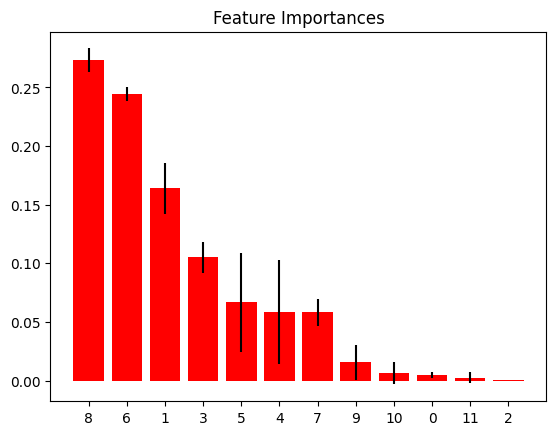

In [91]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print('Feature Ranking')
df = pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)

print(df.sort_values('importance', ascending=False))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title('Feature Importances')
plt.bar(range(x_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# 10. Machine Learning

- We are not trying to find the best model to know whether the person will buy it or not.
- The intention is to create a list with a ranking of the people most likely to purchase.
- We are interested in a good model capable of ordering a list. That's why we use ordering metrics (accumulated curve)

In [92]:
df6 = df5.copy()

cols_selected = ['vintage', 'annual_premium', 'age', 'region_code',
                 'vehicle_damage', 'policy_sales_channel',
                 'previously_insured']

x_train = df5[cols_selected]
x_valid = x_val[cols_selected]
y_val = y_val.copy()

## 10.1 KNN

In [93]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=7)

# model training
knn_model.fit(x_train, y_train)

# model prediction - Generalization, not Learning
yhat_knn = knn_model.predict_proba(x_valid)

## 10.2 Logistic Regression

In [94]:
# model definition
lr_model = lm.LogisticRegression(random_state=42)

# model training
lr_model.fit(x_train, y_train)

# model prediction
yhat_lr = lr_model.predict_proba(x_valid)

## 10.3 Extra Tree

In [95]:
# model definition
et = en.ExtraTreesClassifier(n_estimators=100, n_jobs=-1, random_state=42)

# model training
et.fit(x_train, y_train)

# model prediction
yhat_et = et.predict_proba(x_valid)

## 10.4 Models Comparation

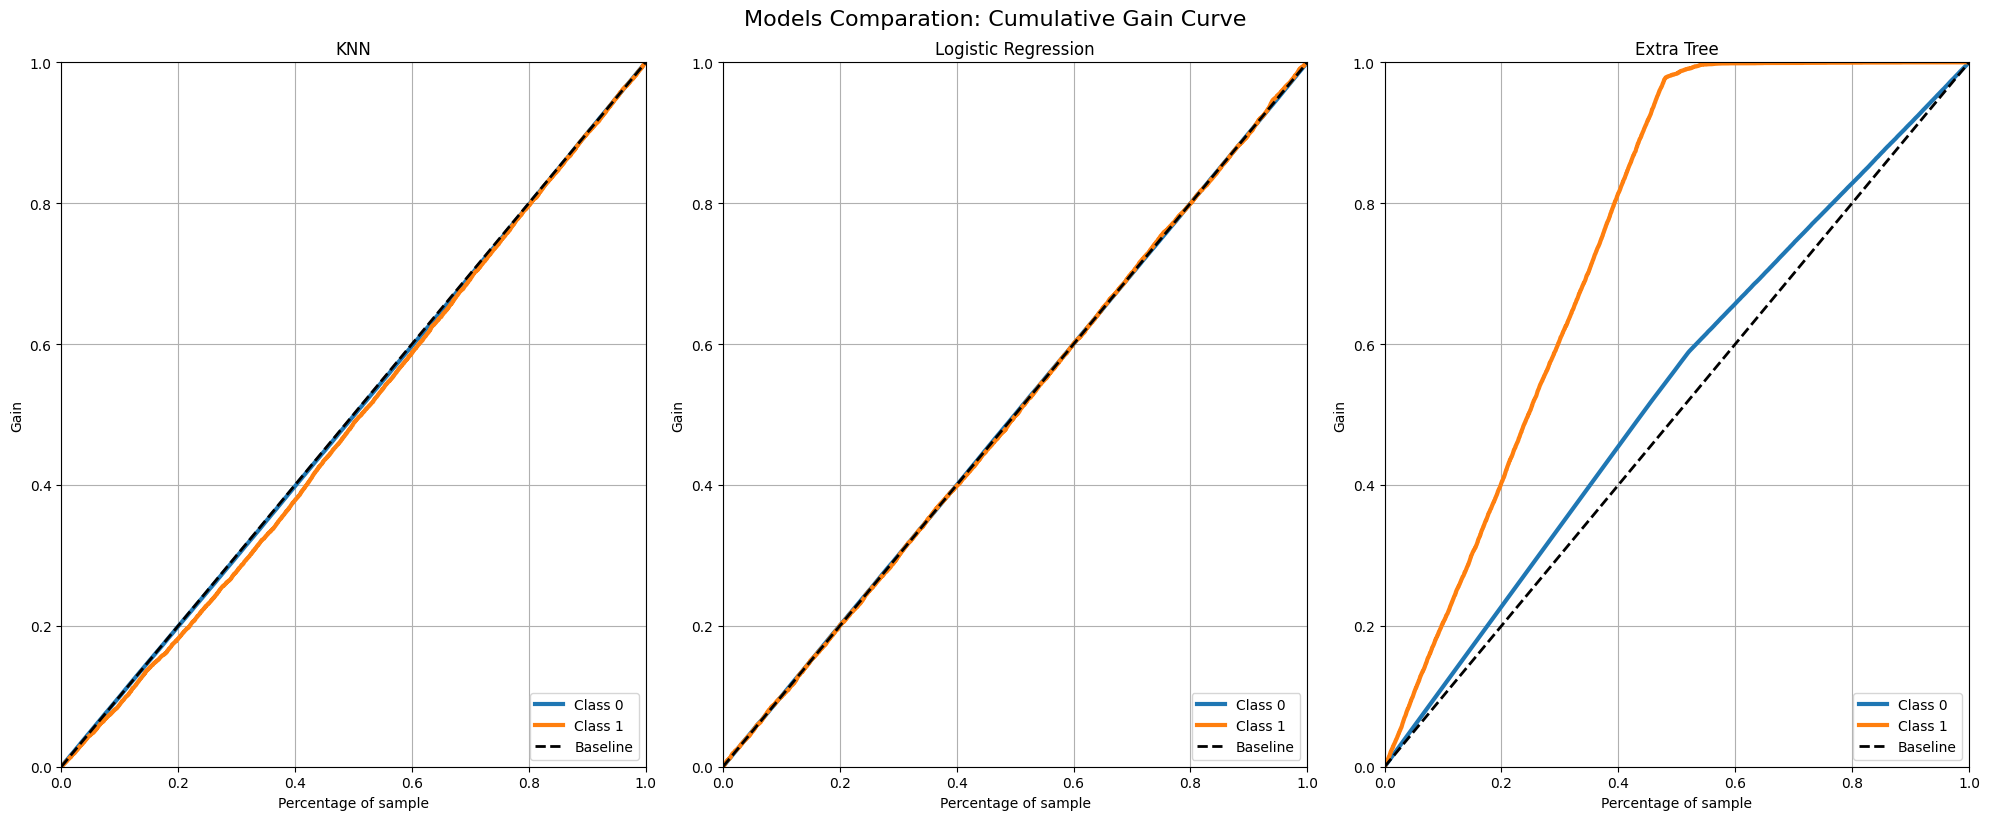

In [96]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# KNN
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn, ax=axes[0])
axes[0].set_title('KNN')

# Logistic Regression
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr, ax=axes[1])
axes[1].set_title('Logistic Regression')

# Extra Tree
skplt.metrics.plot_cumulative_gain(y_val, yhat_et, ax=axes[2])
axes[2].set_title('Extra Tree')

plt.tight_layout()
fig.suptitle('Models Comparation: Cumulative Gain Curve', fontsize=16, y=1.02)
plt.show()


### Ao final, vamos responder:

- x% da minha base de clientes, ordenados pela probabilidade de compra, contém y% de todos os interessados no novo produto.

## 10.5 Models Performance

In [97]:
knn_metrics = metrics_models(df6, 'KNN Classifier', y_val, yhat_knn, x_valid)
lr_metrics = metrics_models(df6, 'Logistic Regression', y_val, yhat_lr, x_valid)
et_metrics = metrics_models(df6, 'Extra Tree', y_val, yhat_et, x_valid)
all_metrics = pd.concat([knn_metrics, lr_metrics, et_metrics], axis=0)
all_metrics.sort_values(by='Precision at K', ascending=False)

,Model Name,Precision at K,Recall at K
0,Extra Tree,0.241879,0.052478
0,KNN Classifier,0.114443,0.024829
0,Logistic Regression,0.113443,0.024612


# 11. Deploy to Production

In [98]:
# Save trained model
pickle.dump(lr_model, open("C:/Users/Felipe/Documents/Felipe/CienciaDeDados/repos/purchasing_propensity/src/models/model_health_insurance_cross_sell.pkl", 'wb'))

## 11.1 Class for Model Production

In [99]:
import pickle
import pandas as pd
import inflection


class HealthInsurance(object):
    def __init__(self):
        self.home_path = ('C:/Users/Felipe/Documents/Felipe/CienciaDeDados/'
                          'repos/purchasing_propensity/')

        path1 = f"{self.home_path}src/features/annual_premium_scaler.pkl"
        self.annual_premium_scaler = pickle.load(open(path1, 'rb'))

        path2 = f"{self.home_path}src/features/age_scaler.pkl"
        self.age_scaler = pickle.load(open(path2, 'rb'))

        path3 = f"{self.home_path}src/features/vintage_scaler.pkl"
        self.vintage_scaler = pickle.load(open(path3, 'rb'))

        path4 = f"{self.home_path}src/features/target_encode_gender_scaler.pkl"
        self.target_encode_gender_scaler = pickle.load(open(path4, 'rb'))

        path5 = f"{self.home_path}src/features/target_encode_region_code_scaler.pkl"
        self.target_encode_region_code_scaler = pickle.load(open(path5, 'rb'))

        path6 = f"{self.home_path}src/features/fe_policy_sales_channel_scaler.pkl"
        self.fe_policy_sales_channel_scaler = pickle.load(open(path6, 'rb'))

    def rename_columns(data):
        new_columns = {col: inflection.underscore(col) for col in data.columns}
        return data.rename(columns=new_columns)

    def feature_engineering(data):
        # vehicle age
        data['vehicle_age'] = data['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' 
                                                    else 'between_1_2_year' if x == '1-2 Year' 
                                                    else 'below_1_year' ) 

        # vehicle damage
        data['vehicle_damage'] = data['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

        return data

    def data_preparation(self, data):
        # annual premium - StandardScaler
        data['annual_premium'] = (self.annual_premium_scaler
                                  .transform(data[['annual_premium']].values))

        # Age - MinMaxScaler
        data['age'] = self.age_scaler.transform(data[['age']].values)

        # vintage
        data['vintage'] = (self.vintage_scaler.transform(data[['vintage']]
                                                         .values))

        # gender - Target Encoding
        data.loc[:, 'gender'] = (data['gender']
                                 .map(self.target_encode_gender_scaler))

        # region_code - Target Encoding
        data.loc[:, 'region_code'] = (data['region_code']
                                      .map(self.
                                           target_encode_region_code_scaler))

        # vehicle_age - One Hot Encoding
        data = (pd.get_dummies(data, prefix='vehicle_age',
                               columns=['vehicle_age']))

        # policy_sales_channel - Target Encoding / Frequency Encoding (!)
        data.loc[:, 'policy_sales_channel'] = (
            data['policy_sales_channel']
            .map(self.fe_policy_sales_channel_scaler))

        # Feature selection
        cols_selected = ['vintage', 'annual_premium', 'age', 'region_code',
                         'vehicle_damage', 'policy_sales_channel',
                         'previously_insured']

        return data[cols_selected]

    def get_prediction(self, model, original_data, test_data):
        # model prediction
        pred = model.predict_proba(test_data)

        # join prediction into original data
        original_data['score'] = pred

        return original_data.to_json(orient='records', date_format='iso')


## 11.2 API Handler

In [100]:
# loading model
path = 'C:/Users/Felipe/Documents/Felipe/CienciaDeDados/repos/purchasing_propensity/src/models/'
model = pickle.load(open(path + 'model_linear_regression.pkl', 'rb'))

# initialize API
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def health_insurance_predict():
    test_json = request.get_json()

    if test_json: # there is data
        if isinstance(test_json, dict): # unique exemple
            test_raw = pd.DataFrame(test_json, index=[0])
        else: # multiple exemples
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

        # Instantiate HealthInsurance class
        pipeline = HealthInsurance()

        # Data cleaning
        df1 = pipeline.data_cleaning(test_raw)

        # Feature Engineering
        df2 = pipeline.feature_engineering(df1)

        # Data Preparation
        df3 = pipeline.data_preparation(df2)

        # Prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)

        return df_response

    else:
        return Response( '{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    app.run( '0.0.0.0' )


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.15.6:5000
Press CTRL+C to quit


## 11.3 API Tester

In [101]:
df_test = x_val
df_test['response'] = y_val

In [102]:
df_test = df_test.sample(10)

In [103]:
df_test.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
299504,299505,Male,53,1,41.0,0,between_1_2_year,1,44743.0,26.0,241,0
2088,2089,Female,39,1,28.0,0,between_1_2_year,1,2630.0,124.0,211,0
244465,244466,Male,53,1,2.0,0,between_1_2_year,1,28674.0,124.0,17,0
217099,217100,Male,22,1,15.0,1,below_1_year,0,31315.0,152.0,286,0
272753,272754,Female,60,1,28.0,0,between_1_2_year,1,49286.0,122.0,244,0


In [104]:
# convert dataframe to json
data = json.dumps(df_test.to_dict(orient='records'))

In [109]:
# API Call
#url = 'http://localhost:5000/predict'
url = 'https://insurancecrosssell.onrender.com/'
header = {'Content-type': 'application/json' }

r = requests.post(url, data=data, headers=header)
print('Status Code {}'.format( r.status_code ))

Status Code 500


In [54]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())
d1.sort_values('score', ascending=False).head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,score
9,331763,Male,61,1,28.0,0,between_1_2_year,1,36053.0,124.0,148,0,0.048905
1,339543,Male,67,1,28.0,0,between_1_2_year,1,26889.0,124.0,232,0,0.047895
6,132188,Female,34,1,14.0,0,between_1_2_year,1,2630.0,156.0,32,0,0.038316
4,169103,Female,43,1,8.0,0,between_1_2_year,1,74038.0,124.0,73,1,0.034507
5,115156,Male,23,1,10.0,0,below_1_year,0,23506.0,152.0,83,0,0.026912
